In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import tempfile
from io import StringIO
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


In [48]:
pitching = pd.read_csv("data/pitchingsince2015.csv")
batting = pd.read_csv("data/battingsince2015.csv")
standings = pd.read_csv("data/ivy_league_standings_2015_to_2019.csv")
park_factors = pd.read_csv("data/park_factors.csv")
ivy_pitching = pd.read_excel("data/ivy_league_totals_2012_to_2020.xlsx", sheet_name="pitching")
ivy_pitching = ivy_pitching.set_index("Season")
ivy_batting = pd.read_excel("data/ivy_league_totals_2012_to_2020.xlsx", sheet_name="batting")
ivy_batting = ivy_batting.set_index("Season")

In [49]:
def get_games(team_name, start,end):
    """
    Returns: a dataframe of all games played for a given team inclusive of given start & end year
    
    Parameter team_name: team whose games to select 
    Precondition: team_name is a lowercase string
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "team_name invalid, must be int"
    assert type(end) == int, "team_name invalid, must be int"
    payload = {"team1":team_name, "firstyear":str(start), "team2":"all","lastyear":str(end), "format":"Text", "submit":"Fetch"}
    url = "http://www.boydsworld.com/cgi/scores.pl?" 
    s = requests.Session()
    r = requests.get(url, params = payload)
    response = r.text 
    if (len(response) < 10):
        return pd.DataFrame
    else:
        df = pd.read_fwf(StringIO(response), encoding = 'utf8',header=None)
        col_names = ["date", "team_1", "team_1_score", "team_2", "team_2_score", "field"]
        try: 
            df.shift(periods=1)
            df.columns = col_names
        except:          
            df.columns = df.columns.astype("str")
            df.drop("2", inplace=True, axis=1)
            df.columns = col_names
        return df

In [50]:
def get_wins(team_name, start, end):
    """
    Returns a dataframe of victories of a given team

    Parameter team_name: team to return victories of 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """        
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "team_name invalid, must be int"
    assert type(end) == int, "team_name invalid, must be int"
    games = get_games(team_name,start,end)
    wins = games[(games["team_1"] == team_name) & (games["team_1_score"] > games["team_2_score"])]
    return wins

In [51]:
def get_wins_from_df(team_name, games):
    """
    Returns a dataframe of victories of a given team from given get_games dataframe

    Parameter team_name: team to return victories of 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: Games to filter 
    Precondition: games is a DataFrame returned by getGames() function
    """        
    assert type(team_name) == str, "team_name invalid, must be string"
    wins = games[(games["team_1"] == team_name) & (games["team_1_score"] > games["team_2_score"])]
    return wins

In [52]:
def get_losses(team_name, start, end):
    """
    Returns a dataframe of losses of a given dataframe 

    Parameter team_name: team to return losses of 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """        
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "start years invalid, must be int"
    assert type(end) == int, "end year invalid, must be int"
    games = get_games(team_name,start,end)
    losses = games[(games["team_2"] == team_name) & (games["team_1_score"] > games["team_2_score"])]
    return losses

In [53]:
def get_losses_from_df(team_name, games):
    """
    Returns a dataframe of losses of a given dataframe from get_games dataframe

    Parameter team_name: team to return losses of 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: Games to filter 
    Precondition: games is a DataFrame returned by getGames() function
    """        
    assert type(team_name) == str, "team_name invalid, must be string"
    losses = games[(games["team_2"] == team_name) & (games["team_1_score"] > games["team_2_score"])]
    return losses

In [54]:
def get_intra_ivy(team_name, start, end):
    """
    Returns: data frame of in-conference games of given team. Currently only functional for Ivy League Teams. 
    
     Creates a temporary column "intra_ivy" equal to 1 if against an Ivy-League opponent, 0 if not, and then 
     selects the rows for which this intra_ivy is one. 
    
    Plan to make this work for any team. Conference changes get tricky, will need helper to get conference team list for each season, 
    check each game against per-season list. 
    
    Parameter team_name: team whose games to select 
    Precondition: team_name is a lowercase string
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "start years invalid, must be int"
    assert type(end) == int, "end year invalid, must be int"
    conference = ["Brown","Cornell","Columbia","Dartmouth","Harvard","Pennsylvania","Princeton","Yale"]
    conference.remove(team_name)
    games = get_games(team_name, start, end)
    wins = get_wins_from_df(team_name, games)
    losses = get_losses_from_df(team_name, games)
    wins["intra_ivy"] = [1 if x in conference else 0 for x in wins["team_2"]]
    losses["intra_ivy"] = [1 if x in conference else 0 for x in losses["team_1"]]
    new_df = pd.concat([wins,losses])
    in_conference = new_df[new_df["intra_ivy"] == 1]
    return in_conference

In [55]:
def get_intra_ivy_from_df(team_name, games):  
    """
    Returns: data frame of in-conference games of given team from get_games dataframe
    
     Creates a temporary column "intra_ivy" equal to 1 if against an Ivy-League opponent, 0 if not, and then 
     selects the rows for which this intra_ivy is one. 
    
    Plan to make this work for any team. Conference changes get tricky, will need helper to get conference team list for each season, 
    check each game against per-season list. 
    
    Parameter team_name: team whose games to select 
    Precondition: team_name is a lowercase string
    Parameter games: Games to filter 
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    conference = ["Brown","Cornell","Columbia","Dartmouth","Harvard","Pennsylvania","Princeton","Yale"]
    conference.remove(team_name)
    wins = get_wins_from_df(team_name, games)
    losses = get_losses_from_df(team_name, games)
    wins["intra_ivy"] = [1 if x in conference else 0 for x in wins["team_2"]]
    losses["intra_ivy"] = [1 if x in conference else 0 for x in losses["team_1"]]
    new_df = pd.concat([wins,losses])
    in_conference = new_df[new_df["intra_ivy"] == 1]
    return in_conference

In [56]:
def get_runs_scored(team_name,start, end):
    """
    Returns: int equal to total number of runs scored by team_name over given games
    
    Parameter team_name: team to calculate runs scored for 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "start years invalid, must be int"
    assert type(end) == int, "end year invalid, must be int"
    games = get_games(team_name, start, end)
    wins = get_wins_from_df(team_name, games)
    wins["winner_runs_scored"] = wins["team_1_score"]
    losses = get_losses_from_df(team_name, games)
    losses["loser_runs_scored"] = losses["team_2_score"] 
    sum_runs_scored_in_wins = wins["winner_runs_scored"].sum()
    sum_runs_scored_in_losses = losses["loser_runs_scored"].sum()
    result = sum_runs_scored_in_wins+sum_runs_scored_in_losses
    return result

In [57]:
def get_runs_scored_from_df (team_name, games):
    """
    Returns: int equal to total number of runs scored by team_name over given games

    Parameter team_name: team to calculate runs scored for 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: games to aggregate over 
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    wins = get_wins_from_df(team_name, games)
    wins["winner_runs_scored"] = wins["team_1_score"]
    losses = get_losses_from_df(team_name, games)
    losses["loser_runs_scored"] = losses["team_2_score"] 
    sum_runs_scored_in_wins = wins["winner_runs_scored"].sum()
    sum_runs_scored_in_losses = losses["loser_runs_scored"].sum()
    result = sum_runs_scored_in_wins+sum_runs_scored_in_losses
    return result

In [58]:
def get_runs_allowed(team_name, start, end):
    """
    Returns: int equal to total number of runs allowed by team_name over given games
    
    Parameter team_name: team to calculate runs allowed for 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "start years invalid, must be int"
    assert type(end) == int, "end year invalid, must be int"
    games = get_games(team_name,start,end)
    wins = get_wins_from_df(team_name, games)
    wins["winner_runs_allowed"] = wins["team_2_score"]
    losses = get_losses_from_df(team_name, games)
    losses["loser_runs_allowed"] = losses["team_1_score"] 
    sum_runs_allowed_in_wins = wins["winner_runs_allowed"].sum()
    sum_runs_allowed_in_losses = losses["loser_runs_allowed"].sum()
    result = sum_runs_allowed_in_wins + sum_runs_allowed_in_losses
    return result

In [59]:
def get_runs_allowed_from_df(team_name, games):
    """
    Returns: int equal to total number of runs allowed by team_name over given get_games dataframe
    
    Parameter team_name: team to calculate runs allowed for 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: games to aggregate over 
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    wins = get_wins_from_df(team_name, games)
    wins["winner_runs_allowed"] = wins["team_2_score"]
    losses = get_losses_from_df(team_name, games)
    losses["loser_runs_allowed"] = losses["team_1_score"] 
    sum_runs_allowed_in_wins = wins["winner_runs_allowed"].sum()
    sum_runs_allowed_in_losses = losses["loser_runs_allowed"].sum()
    result = sum_runs_allowed_in_wins + sum_runs_allowed_in_losses
    return result

In [60]:
def get_run_difference(team_name, start, end):
    """
    Returns: The total run difference across a given set of games 
    
    Parameter team_name: team to return run difference of
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter start: the start year of games. To select only games from one year, leave  
    Precondition: start is an int
    Parameter end: the end year of games
    Precondition: end is an int
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    assert type(start) == int, "start years invalid, must be int"
    assert type(end) == int, "end year invalid, must be int"
    games  = get_games(team_name, start, end)
    scored = get_runs_allowed_from_df(team_name, games)
    allowed = get_runs_scored_from_df(team_name, games)
    result = scored - allowed
    return result

In [61]:
def get_run_difference_from_df(team_name, games):
    """
    Returns: The total run difference across a given set of get_games dataframe
    
    Parameter team_name: team to return run difference of
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: Games to filter 
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    scored = get_runs_allowed_from_df(team_name, games)
    allowed = get_runs_scored_from_df(team_name, games)
    result = scored - allowed
    return result

In [62]:
def add_run_difference_column(team_name, games):
    """
    Returns copy with a given dataframe with new column containing the run difference for each game for a given team.

    Parameter team_name: team to return run difference of
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"Precondtion: 
    Parameter games: Games to filter 
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    df_copy = games.copy()
    dif_in_wins = df_copy["team_1_score"] - df_copy["team_2_score"]
    dif_in_losses = df_copy["team_2_score"] - df_copy["team_1_score" ]
    df_copy["run_difference"] = np.where(((df_copy["team_1"] == team_name) & (df_copy["team_1_score"] > df_copy["team_2_score"])), dif_in_wins, dif_in_losses)
    df_copy["opponent"] = np.where(((df_copy["team_1"] == team_name) & (df_copy["team_1_score"] > df_copy["team_2_score"])), df_copy["team_2"], df_copy["team_1"])
    df_copy["cumulative_rd"] = df_copy["run_difference"].cumsum()
    return df_copy

In [63]:
def pythag_win_percentage_from_df(team_name, games):
    """
    Returns: The PythagenPat winning percentage expectation of a given team over given games. 

    W% = R^x/(R^x + RA^x)
    where x = (RPG)^.287
    Developed by David Smyth and Patriot
   
    Parameter team_name: team to return expected winning % for 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: games over which to calculate
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    run_diff =  get_run_difference_from_df(team_name, games)
    runs_scored = get_runs_scored_from_df(team_name, games)
    runs_allowed = get_runs_allowed_from_df(team_name, games)    
    num_games = len(games.index)
    if not num_games == 0:
        runs_per_game = runs_scored / num_games
    else:
        runs_per_game = 0
    x = runs_per_game ** 0.287
    result  = (runs_scored ** x) / ((runs_scored ** x) + (runs_allowed ** x))
    return result

In [64]:
def actual_win_percentage_from_df(team_name, games):
    """
    Returns: The actual (i.e. experimental) winning percentage of a given team over given games. 

    winning_percentage = games_won / games_plated
   
    Parameter team_name: team to return actual winning % for 
    Preconditions: team_name is a string format ex. "Cornell," "Colgate"
    Parameter games: games over which to calculate
    Precondition: games is a DataFrame returned by getGames() function
    """
    assert type(team_name) == str, "team_name invalid, must be string"
    wins = get_wins_from_df(team_name, games)
    losses = get_losses_from_df(team_name,games)
    num_wins = len(wins.index)
    num_losses = len(losses.index)
    win_percentage = num_wins / (num_wins+num_losses)
    return win_percentage

In [65]:
games = get_games("Cornell", 2015, 2020)
games

,date,team_1,team_1_score,team_2,team_2_score,field
0,2/21/2015,Gardner-Webb,2,Cornell,1,@Gardner-Webb
1,2/21/2015,Gardner-Webb,3,Cornell,2,@Gardner-Webb
2,2/22/2015,Gardner-Webb,2,Cornell,1,@Gardner-Webb
3,2/27/2015,Seton Hall,3,Cornell,0,@neutral
4,2/28/2015,Cornell,4,Hartford,3,@neutral
...,...,...,...,...,...,...
194,2/29/2020,Niagara,8,Cornell,6,@neutral
195,3/01/2020,Cornell,6,Niagara,5,@neutral
196,3/06/2020,South Carolina,10,Cornell,2,@South Carolina
197,3/07/2020,South Carolina,10,Cornell,3,@South Carolina


In [66]:
def get_rd_data(team_name, start, end):
        """
        Returns: Dataframe with run_difference, opponent, and cumulative_rd for every game of given team
        in given seasons. 
        
        Parameter team_name: team to return games for
        Precondtion: team_name is a string
        Parameter start: start year, inclusive
        Precondition: start is a int 
        Parameter end: end year, inclusive
        Preconditon: end is an int
        """
        games = get_games(team_name, start=start, end=end)
        games["date"] =  pd.to_datetime(games["date"])
        games = games.sort_values(by="date")
        games = games.reset_index(drop="True")
        games = add_run_difference_column(team_name, games)
        games = games.drop(columns=["team_1","team_1_score","team_2","team_2_score","field"])
        games["date"] = games["date"].dt.strftime('%Y-%m-%d')
        return games
    
get_rd_data("Cornell",2010,2020)

,date,run_difference,opponent,cumulative_rd
0,2010-03-16,-2,Binghamton,-2
1,2010-03-16,5,Binghamton,3
2,2010-03-21,1,Northwestern,4
3,2010-03-22,1,Northwestern,5
4,2010-03-23,-5,Florida Atlantic,0
...,...,...,...,...
399,2020-02-29,-2,Niagara,-274
400,2020-03-01,1,Niagara,-273
401,2020-03-06,-8,South Carolina,-281
402,2020-03-07,-7,South Carolina,-288


In [67]:
# Pythagenpat intra-conference win %'s by team for the Ivy League
def generate_ivy_pythags(start, end):
    """
    Returns: Dataframe of actual and expected winning percentages of Ivy League for a given set of seasons. 
    Parameter start: start year, inclusive
    Precondition: start is an int YYYY
    Parameter end: end year, inclusive
    Precondtion: end is an int YYYY
    """
    assert type(start) == int, "start must be an int"
    assert type(end) == int, "end must be an int"
    ivy_pythagenpat = {"team_name":[], "pythagenpat_pct":[], "actual_pct":[], "deviation":[]};
    for i in ["Brown", "Columbia", "Cornell", "Dartmouth", "Harvard", "Pennsylvania", "Princeton", "Yale"]:
        games = get_intra_ivy(i,start,end)
        pythagenpat_pct = pythag_win_percentage_from_df(i,games)  
        actual_pct = actual_win_percentage_from_df(i,games)  
        deviation = abs(round(pythagenpat_pct - actual_pct,2))
        ivy_pythagenpat["team_name"].append(i)
        ivy_pythagenpat["pythagenpat_pct"].append(round(pythagenpat_pct,2))
        ivy_pythagenpat["actual_pct"].append(round(actual_pct,2))
        ivy_pythagenpat["deviation"].append(deviation)
        results = pd.DataFrame(ivy_pythagenpat)
    return results

generate_ivy_pythags(2015,2020)

,team_name,pythagenpat_pct,actual_pct,deviation
0,Brown,0.40,0.35,0.04
1,Columbia,0.60,0.62,0.02
2,Cornell,0.44,0.41,0.02
3,Dartmouth,0.54,0.56,0.02
4,Harvard,0.53,0.49,0.04
5,Pennsylvania,0.62,0.56,0.05
6,Princeton,0.37,0.39,0.02
7,Yale,0.52,0.59,0.06


In [68]:
def get_woba(player_id, year):
    """
    Returns: The Weighted On-Base Average  for a given player in a given season
    
    wOBA = (wBB×uBB + wHBP×HBP + w1B×1B + w2B×2B + w3B×3B +
    wHR×HR) / (AB + BB – IBB + SF + HBP)
    PA = AB + BB - IBB + SF + HBP 
    
    Parameter player_id: The ID of player to return for
    Precondition: player_id is 
    Parameter year: The season to return for 
    Precondition: year is an INT 
    """
    season_batting = pd.read_csv("data/cornellbatting"+str(year)+".csv")
    player_batting =  season_batting[season_batting.player_id==player_id]
    player_batting = player_batting.fillna(0)
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season==year]
    wbb = season_weights["wBB"].values[0]
    whbp = season_weights["wHBP"].values[0]
    w1b = season_weights["w1B"].values[0]
    w2b = season_weights["w2B"].values[0]
    w3b = season_weights["w3B"].values[0]
    whr = season_weights["wHR"].values[0]
    walks = player_batting["BB"].values[0]
    hits_by_pitch = player_batting["HBP"].values[0]
    doubles = player_batting["2B"].values[0]
    triples = player_batting["3B"].values[0]
    home_runs = player_batting["HR"].values[0]
    hits =  player_batting["H"].values[0]
    singles = hits-(doubles+triples+home_runs)
    at_bats = player_batting["AB"].values[0]
    sac_flies = player_batting["SF"].values[0]
    sac_bunts = player_batting["SH"].values[0]
    plate_appearances = at_bats+walks+sac_flies+sac_bunts+hits_by_pitch
    woba = (wbb*walks+whbp*hits_by_pitch+w1b*singles+w2b*doubles+w3b*triples+whr*home_runs)/plate_appearances
    return woba

get_woba(1779085, 2017)

0.44225271739130434

In [69]:
def get_wraa(player_id, year):
    """
    Returns: The Weighted Runs Above Average (wRAA) for a given player in a given season
    
    [(wOBA−leagueWOBA) / wOBAscale] ∗ PA
    PA = AB + BB - IBB + SF + HBP 

    Parameter player_id: The ID of player to return for
    Precondition: player_id is 
    Parameter year: The season to return wRC for 
    Precondition: year is an INT 
    """
    season_batting = pd.read_csv("data/cornellbatting"+str(year)+".csv")
    player_batting =  season_batting[season_batting.player_id==player_id]
    player_batting = player_batting.fillna(0)
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season== year]
    league_woba = season_weights["wOBA"].values[0]
    woba_scale = season_weights["wOBAScale"].values[0]
    league_runs_per_pa = season_weights["R/PA"].values[0]
    player_woba = get_woba(player_id, year)
    at_bats = player_batting["AB"].values[0]
    walks = player_batting["BB"].values[0]
    sac_flies = player_batting["SF"].values[0]
    sac_bunts = player_batting["SH"].values[0]
    hits_by_pitch = player_batting["HBP"].values[0]
    plate_appearances = at_bats+walks+sac_flies+sac_bunts+hits_by_pitch
    wraa = ((((player_woba-league_woba)/woba_scale)))*(plate_appearances)
    return wraa

get_wraa(1779085,2017)

7.687957875457876

In [70]:
def get_wrc(player_id, year):
    """
    Returns: The Weighted Runs Created  for a given player in a given season
    
    wRC = [((wOBA - lgwOBA)/wOBAScale) + (lgR/PA)] * PA
    PA = AB + BB - IBB + SF + HBP 

    Parameter player_id: The ID of player to return for
    Precondition: player_id is 
    Parameter year: The season to return for 
    Precondition: year is an INT 
    """
    season_batting = pd.read_csv("data/cornellbatting"+str(year)+".csv")
    player_batting =  season_batting[season_batting.player_id==player_id]
    player_batting = player_batting.fillna(0)
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season==year]
    league_woba = season_weights["wOBA"].values[0]
    woba_scale = season_weights["wOBAScale"].values[0]
    league_runs_per_pa = season_weights["R/PA"].values[0]
    player_woba = get_woba(player_id, year)   
    at_bats = player_batting["AB"].values[0]
    walks = player_batting["BB"].values[0]
    sac_flies = player_batting["SF"].values[0]
    sac_bunts = player_batting["SH"].values[0]
    hits_by_pitch = player_batting["HBP"].values[0]
    plate_appearances = at_bats+walks+sac_flies+sac_bunts+hits_by_pitch
    wrc = ((((player_woba-league_woba)/woba_scale)+league_runs_per_pa))*plate_appearances
    return wrc

get_wrc(1779085,2017)

20.843957875457875

In [71]:
def get_cornell_woba(year):
    """
    Returns: The Weighted On-Base Average  for a given player in a given season
    
    wOBA = (wBB×uBB + wHBP×HBP + w1B×1B + w2B×2B + w3B×3B +
    wHR×HR) / (AB + BB – IBB + SF + HBP)
    PA = AB + BB - IBB + SF + HBP 

    Parameter year: The season to return for 
    Precondition: year is an INT 2012-2020
    """
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season==year]
    wbb = season_weights["wBB"].values[0]
    whbp = season_weights["wHBP"].values[0]
    w1b = season_weights["w1B"].values[0]
    w2b = season_weights["w2B"].values[0]
    w3b = season_weights["w3B"].values[0]
    whr = season_weights["wHR"].values[0]
    totals = pd.read_excel("data/cornell_totals_2012_to_2020.xlsx")
    season_totals = totals[totals.Season==year]
    walks = season_totals["BB"].values[0]
    hits_by_pitch = season_totals["HBP"].values[0]
    doubles = season_totals["2B"].values[0]
    triples = season_totals["3B"].values[0]
    home_runs = season_totals["HR"].values[0]
    hits = season_totals["H"].values[0]
    singles =  hits-(doubles+triples+home_runs)
    at_bats = season_totals["AB"].values[0]
    sac_flies = season_totals["SF"].values[0]
    sac_bunts = season_totals["SH"].values[0]
    plate_appearances = at_bats+walks+sac_flies+sac_bunts+hits_by_pitch
    woba = (wbb*walks+whbp*hits_by_pitch+w1b*singles+w2b*doubles+w3b*triples+whr*home_runs)/plate_appearances
    return woba

get_cornell_woba(2019)

0.2962856623931624

In [72]:
def get_ivy_woba(year):
        """
        Returns: Ivy League Weighted On-Base Average in a given season

        wOBA = (wBB×uBB + wHBP×HBP + w1B×1B + w2B×2B + w3B×3B +
        wHR×HR) / (AB + BB – IBB + SF + HBP)
        PA = AB + BB - IBB + SF + HBP 

        Parameter year: The season to return for 
        Precondition: year is an INT 2012-2020
        """  
        linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
        season_weights = linear_weights[linear_weights.Season==year]
        wbb = season_weights["wBB"].values[0]
        whbp = season_weights["wHBP"].values[0]
        w1b = season_weights["w1B"].values[0]
        w2b = season_weights["w2B"].values[0]
        w3b = season_weights["w3B"].values[0]
        whr = season_weights["wHR"].values[0]
        ivy_totals = pd.read_excel("data/ivy_league_totals_2012_to_2020.xlsx", sheet_name="batting")
        season_totals = ivy_totals[ivy_totals.Season==year]
        walks = season_totals["BB"].values[0]
        hits_by_pitch = season_totals["HBP"].values[0]
        doubles = season_totals["2B"].values[0]
        triples = season_totals["3B"].values[0]
        home_runs = season_totals["HR"].values[0]
        hits = season_totals["H"].values[0]
        singles =  hits-(doubles+triples+home_runs)
        at_bats = season_totals["AB"].values[0]
        sac_flies = season_totals["SF"].values[0]
        sac_bunts = season_totals["SH"].values[0]
        plate_appearances = at_bats+walks+sac_flies+sac_bunts+hits_by_pitch
        woba = (wbb*walks+whbp*hits_by_pitch+w1b*singles+w2b*doubles+w3b*triples+whr*home_runs)/plate_appearances
        return woba

get_ivy_woba(2018)

0.33472055601974937

In [73]:
def get_fip(player_id, year):
    """
    Returns: Fielding Independent Pitching for a given player in a given season
    
    FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant
    FIP Constant = lgERA – (((13*lgHR)+(3*(lgBB+lgHBP))-(2*lgK))/lgIP)

    Parameter player_id: The ID of player to return for
    Precondition: player_id is 
    Parameter year: The season to return wRC for 
    Precondition: year is an INT 
    """
    season_pitching = pd.read_csv("data/cornellpitching"+str(year)+".csv")
    player_pitching =  season_pitching[season_pitching.player_id==player_id]
    player_pitching = player_pitching.fillna(0)
    strike_outs = player_pitching["SO"].values[0]
    hit_batters = player_pitching["HB"].values[0]
    walks_given = player_pitching["BB"].values[0]
    home_runs_allowed = player_pitching["HR-A"].values[0]
    strike_outs = player_pitching["IP"].values[0]
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season== year]
    fip_constant =season_weights["cFIP"].values[0]
    fip = (((13*home_runs_allowed)+(3*(walks_given+hit_batters))-(2*strike_outs))/strike_outs) + fip_constant
    return fip

get_fip(1546998, 2017)

3.416944055944056

In [74]:
def get_cornell_fip(year):
    """
    Returns: Cornell total  Fielding Independent Pitching (FIP) for a given player in a given season

    FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant
    FIP Constant = lgERA – (((13*lgHR)+(3*(lgBB+lgHBP))-(2*lgK))/lgIP)

    Parameter player_id: The ID of player to return for
    Precondition: player_id is 
    Parameter year: The season to return wRC for 
    Precondition: year is an INT 
    """
    cu_pitching = pd.read_csv("data/cornellpitching"+str(year)+".csv")
    season_totals = cu_pitching[cu_pitching.Player=="Totals"]
    strike_outs = season_totals["SO"].values[0]
    hit_batters = season_totals["HB"].values[0]
    walks_given = season_totals["BB"].values[0]
    home_runs_allowed = season_totals["HR-A"].values[0]
    strike_outs = season_totals["IP"].values[0]
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season== year]
    fip_constant =season_weights["cFIP"].values[0]
    fip = (((13*home_runs_allowed)+(3*(walks_given+hit_batters))-(2*strike_outs))/strike_outs) + fip_constant
    return fip

get_cornell_fip(2015)

3.850534334078569

In [75]:
def get_ivy_fip(year):
    """
    Returns: Ivy League total Fielding Independent Pitching (FIP) for a given season
    
    FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant
    FIP Constant = lgERA – (((13*lgHR)+(3*(lgBB+lgHBP))-(2*lgK))/lgIP)

    Parameter year: The season to return fip for 
    Precondition: year is an INT 
    """
    ivy_pitching = pd.read_excel("data/ivy_league_totals_2012_to_2020.xlsx", sheet_name="pitching")
    season_totals = ivy_pitching[ivy_pitching.Season==year]
    walks = season_totals["BB"].values[0]   
    strike_outs = season_totals["SO"].values[0]
    hit_batters = season_totals["HB"].values[0]
    walks_given = season_totals["BB"].values[0]
    home_runs_allowed = season_totals["HR-A"].values[0]
    strike_outs = season_totals["IP"].values[0]
    linear_weights = pd.read_csv("data/ncaa_d1_woba_linear_weights.csv")
    season_weights = linear_weights[linear_weights.Season== year]
    fip_constant =season_weights["cFIP"].values[0]
    fip = (((13*home_runs_allowed)+(3*(walks_given+hit_batters))-(2*strike_outs))/strike_outs) + fip_constant
    return fip

get_ivy_fip(2017)

4.506829547519535

In [76]:
def get_era(player_id, year): 
    """
    Returns: ERA for a given player in a given season 
    
    Parameter player_id: The ID of player to return for
    Precondition: player_id is 
    Parameter year: The season to return wRC for 
    Precondition: year is an INT 
    """
    season_pitching = pd.read_csv("data/cornellpitching"+str(year)+".csv")
    player_pitching =  season_pitching[season_pitching.player_id==player_id]
    player_pitching = player_pitching.fillna(0)
    era = player_pitching["ERA"].values[0]
    return era

get_era(1546998, 2017)

2.18

In [77]:
def get_runs_per_ip(player_id, year):
    """
    Returns: runs per innings pitched
    
    runs allowed / innings pitched
    
    """
    season_pitching = pd.read_csv("data/cornellpitching"+str(year)+".csv")
    player_pitching =  season_pitching[season_pitching.player_id==player_id]
    player_pitching = player_pitching.fillna(0)
    runs_allowed = player_pitching["R"].values[0]
    innings_pitched = player_pitching["IP"].values[0]
    res = runs_allowed/innings_pitched
    return res

get_runs_per_ip(1546998, 2017)

0.4020979020979021

In [78]:
def get_cornell_batting_stats(start):
    """
    Returns: 
    """
    batting = pd.read_csv("data/battingsince"+str(start)+".csv")
    batting = batting.loc[batting['BA']>0, :]
    team_list = {"player_id":[], "name":[], "year":[], "AB":[], "woba":[], "wrc":[], "wraa":[], "class_year":[]}
    for i in range(len(batting)):
        player_id = batting.iloc[i, 0]
        player = batting.iloc[i,6]
        year = batting.iloc[i, 1]
        at_bats = batting.iloc[i,15]
        class_year = batting.iloc[i,7]
        woba = get_woba(player_id, year)
        wrc  = get_wrc(player_id, year)
        wraa  = get_wraa(player_id, year)
        team_list["player_id"].append(player_id)
        team_list["AB"].append(at_bats)
        team_list["class_year"].append(class_year)
        team_list["name"].append(player)
        team_list["year"].append(year)
        team_list["woba"].append(woba)
        team_list["wrc"].append(wrc)
        team_list["wraa"].append(wraa)
    res = pd.DataFrame(team_list)
    return res

get_cornell_batting_stats(2015)

,player_id,name,year,AB,woba,wrc,wraa,class_year
0,2347188.0,"Hollerbach, Joe",2020,29.0,0.261942,2.053749,-2.533251,Fr
1,1884385.0,"Carnegie, Alex",2020,24.0,0.305891,3.173484,-1.135516,Sr
2,1997347.0,"Matton, Kalani",2020,29.0,0.301949,3.061895,-1.247105,Jr
3,1997328.0,"Garza, Ramon",2020,30.0,0.306521,3.706064,-1.297936,Jr
4,2347184.0,"Russell, Shane",2020,35.0,0.183941,-0.323973,-5.327973,Fr
...,...,...,...,...,...,...,...,...
81,1439148.0,"Lowell, Eliot",2015,34.0,0.241800,1.639443,-3.977557,Jr
82,1546996.0,"Smith, Jamie",2015,46.0,0.205158,0.341294,-6.508706,So
83,1652421.0,"Le Dorze, Pierre",2015,19.0,0.531137,7.243910,3.955910,Fr
84,1652419.0,"Baur, Trey",2015,24.0,0.259539,1.457032,-2.104968,Fr


In [79]:
def get_cornell_pitching_stats(start):
    """
    Returns: Dataframe of advanced pitching statistics
    """
    pitching = pd.read_csv("data/pitchingsince"+str(start)+".csv")
    pitching = pitching.loc[pitching['App']>0, :]
    team_list = {"player_id":[], "name":[], "year":[], "innings_pitched":[], "runs":[], "era":[], "fip":[], "runs_per_ip":[],"class_year":[]}
    for i in range(len(pitching)):
        player_id = pitching.iloc[i, 0]
        player = pitching.iloc[i,6]
        year = pitching.iloc[i, 1]
        class_year = pitching.iloc[i,7]
        innings_pitched = pitching.iloc[i, 13]
        runs_allowed = pitching.iloc[i, 15]
        era = get_era(player_id, year)
        fip = get_fip(player_id, year)
        runs_per_ip = get_runs_per_ip(player_id, year)
        team_list["player_id"].append(player_id)
        team_list["innings_pitched"].append(innings_pitched)
        team_list["runs"].append(runs_allowed)
        team_list["class_year"].append(class_year)
        team_list["name"].append(player)
        team_list["year"].append(year)
        team_list["era"].append(era)
        team_list["fip"].append(fip)
        team_list["runs_per_ip"].append(runs_per_ip)
    res = pd.DataFrame(team_list)
    return res

get_cornell_pitching_stats(2015)

,player_id,name,year,innings_pitched,runs,era,fip,runs_per_ip,class_year
0,2111707.0,"Lillios, Nikolas",2020,5.1,1.0,1.69,2.497235,0.196078,So
1,2111755.0,"Zacharias, Jon",2020,6.2,9.0,6.75,6.909000,1.451613,So
2,1997345.0,"Davis, Trevor Daniel",2020,4.2,2.0,1.93,6.909000,0.476190,Jr
3,1997324.0,"Urbon, Seth",2020,7.0,6.0,6.43,7.766143,0.857143,Sr
4,1884389.0,"Wyatt, Colby",2020,14.1,17.0,5.65,6.377085,1.205674,Sr
...,...,...,...,...,...,...,...,...,...
79,1547001.0,"Brewer, Ray",2015,12.1,8.0,2.19,4.542917,0.661157,So
80,1652392.0,"McCulley, Zach",2015,12.1,10.0,7.30,5.121430,0.826446,Sr
81,1546997.0,"Veenema, Ryne",2015,5.0,10.0,18.00,9.733000,2.000000,So
82,1439149.0,"Horton, Matt",2015,1.0,5.0,27.00,10.733000,5.000000,Jr


In [80]:
def generate_rd_chart(team_name, start, end):
    """
    generates a cumulative run differential bar chart
    """
    games = sc.get_games(team_name, start=start, end=end)
    games["date"] =  pd.to_datetime(games["date"])
    games = games.sort_values(by="date")
    games = games.reset_index(drop="True")
    games = sc.add_run_difference_column(team_name, games)
    fig = px.bar(games,x=games.index, y="cumulative_rd",
        hover_data=["opponent", "date"], color="cumulative_rd", color_continuous_scale=px.colors.diverging.balance,
        color_continuous_midpoint=0,labels={"cumulative_rd":"Run Differential"})
    fig.update_layout( 
    title = "Cumulative Run Differential<br>"+str(start)+" to "+str(end),
    title_font_size = 20,
    title_xanchor = "center",
    title_yanchor = "top",
    title_x =  0.5,
    yaxis_title="Cumulative Run Differential",
    xaxis_title="Games Played",
    margin=dict(l=40, r=20, t=125, b=20)
    )
    fig.update_yaxes(
    ticklabelposition="inside top",
    )
    fig.update_coloraxes(showscale=False)
    fig.show() 

In [90]:
def generate_ivy_rd_chart(team_name, start, end):
    """
    generates a cumulative run differential bar chart
    """
    games = get_intra_ivy(team_name, start=start, end=end)
    games["date"] =  pd.to_datetime(games["date"])
    games = games.sort_values(by="date")
    games = games.reset_index(drop="True")
    games = add_run_difference_column(team_name, games)
    fig = px.bar(games,x=games.index, y="cumulative_rd",
        hover_data=["opponent", "date"], color="cumulative_rd", color_continuous_scale=px.colors.diverging.balance,
        color_continuous_midpoint=0,labels={"cumulative_rd":"Run Differential"})
    img = Image.open("assets/logos/"+team_name+".png")
    fig.update_layout( 
    title = "Cumulative Run Differential<br>"+str(start)+" to "+str(end),
    title_font_size = 20,
    title_xanchor = "center",
    title_yanchor = "top",
    title_x =  0.5,
    yaxis_title="Cumulative Run Differential",
    xaxis_title="Games Played",
    margin=dict(l=40, r=20, t=125, b=20)
    )
    
    fig.update_yaxes(
    ticklabelposition="inside top",
    )
    fig.add_layout_image(
    dict(
        source=img,
        xref="paper", yref="paper",
        xanchor="left", yanchor="top",
        x=-0.02, y=1.325,
        sizex=0.3, sizey=0.3
        )
    )
    fig.update_coloraxes(showscale=False)
    fig.show() 


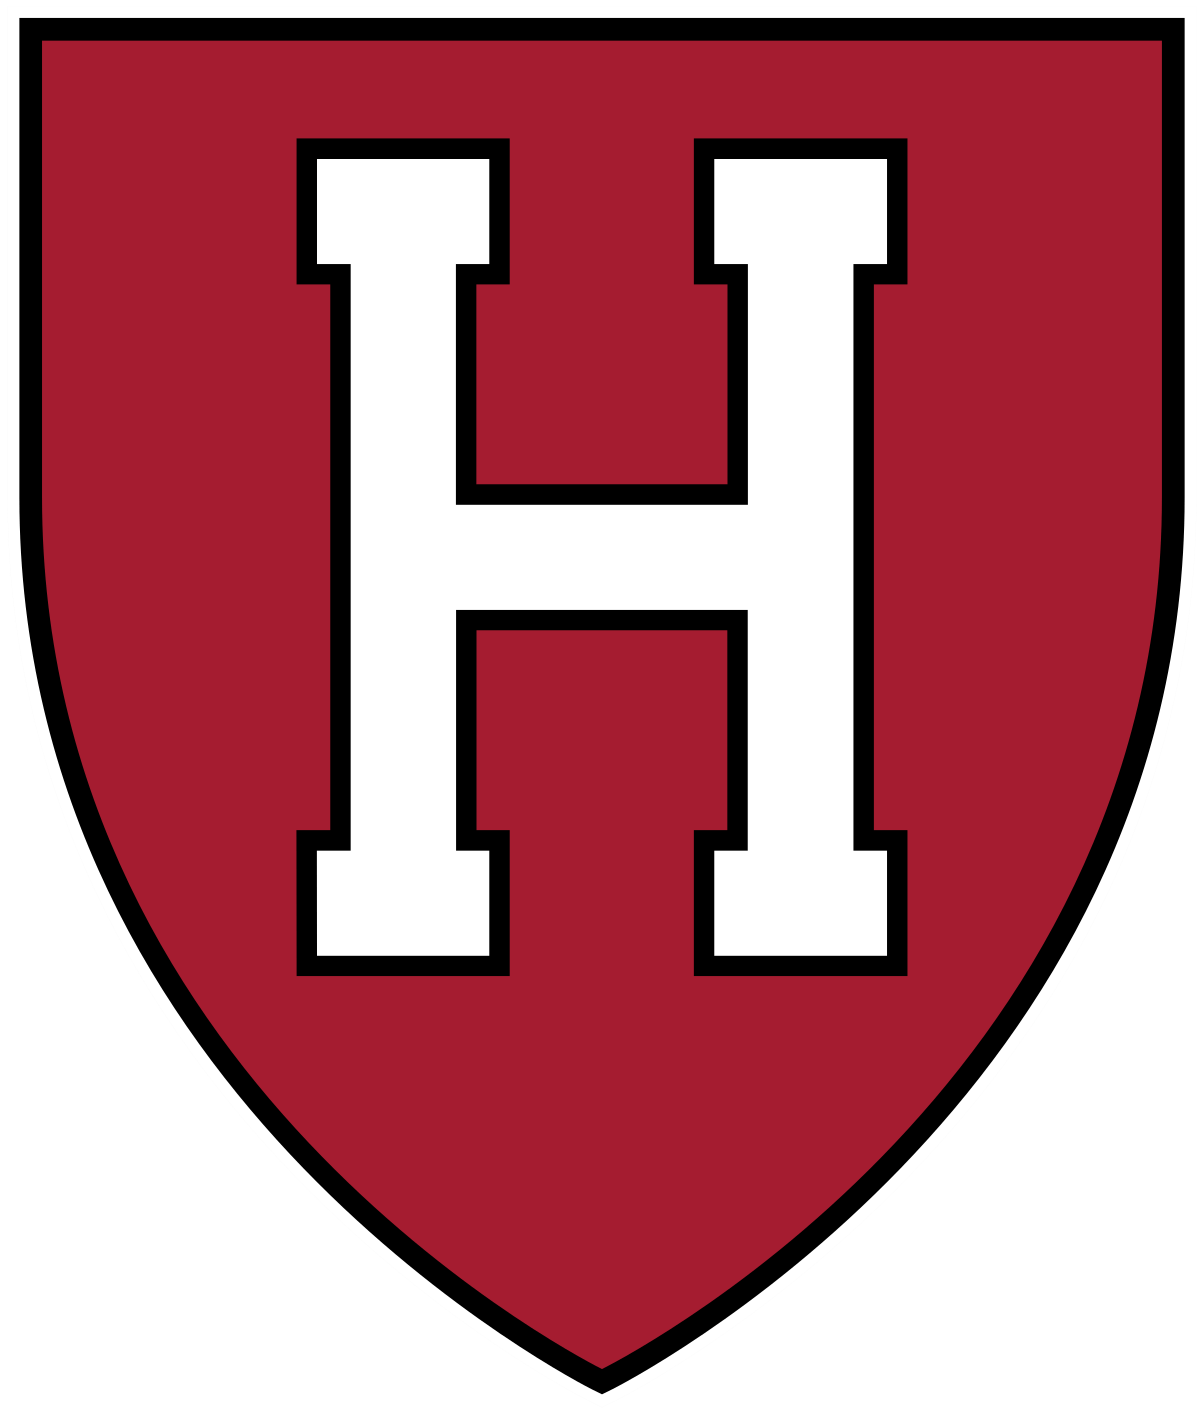

In [96]:
    generate_ivy_rd_chart("Harvard", 2015,2020)

In [82]:
df = generate_ivy_pythags(2015,2020)
start = 2015
end = 2020
fig = px.bar(df, x="team_name", y=["pythagenpat_pct", "actual_pct"], barmode="group")
fig.update_layout( 
title = "Actual vs. Pythagenpat Expected Win Pct.<br>"+str(start)+" to "+str(end),
title_xanchor = "center",
title_yanchor = "top",
title_x =  0.5,
yaxis_title="Percentage",
xaxis_title="School"
)
fig.update_yaxes(
ticklabelposition="inside top",
)
fig.show()

In [83]:
data = get_cornell_batting_stats(2015)
fig = px.scatter(data, x="year", y="wrc", color="wrc", template="ggplot2")
fig.update_layout( 
title = "Cornell Season Batting Performances",
title_yanchor = "top",
title_x =  0.5,
yaxis_title="Weighted Runs Created (wRC)",
xaxis_title=None
)
fig.show()

In [84]:
data = get_cornell_batting_stats(2015)
data = data[data["AB"] > 5]
fig = px.scatter(data, x="year", y="woba", color="woba", template="ggplot2")
fig.update_layout( 
title = "Cornell Individual Batting Performances <br><i>min. 5 AB</i>",
title_yanchor = "top",
title_x =  0.5,
yaxis_title="Weighted On-Base Average (wOBA)",
xaxis_title=None,
)
fig.show()

In [85]:
data = get_cornell_pitching_stats(2015)
fig = px.scatter(data, x="year", y="innings_pitched", hover_name="name", color="innings_pitched",template="ggplot2")
fig.update_layout( 
title = "Innings Pitched by Cornell Pitchers",
title_yanchor = "top",
title_x =  0.5,
yaxis_title="Innings Pitched",
xaxis_title=None
)
fig.show()

In [86]:
data = get_cornell_pitching_stats(2015)
data = data[data["innings_pitched"] > 5]
fig = px.scatter(data, x="year", y="runs_per_ip", color="runs_per_ip", hover_name="name",template="ggplot2")
fig.update_layout( 
title = "Runs/IP Cornell Pitchers by Year since 2015",
title_yanchor = "top",
title_x =  0.5,
yaxis_title="Runs/IP (min 5 IP)",
xaxis_title=None
)
fig.update_yaxes(autorange="reversed")
fig.show()
